## Load Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn import linear_model
import seaborn as sns
# plt.rcParams['figure.figsize'] = (25, 6)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

### Load dataset of probability

In [4]:
prob_data = pd.read_csv('final_model_data/RealProbs.csv')
prob_data.shape

(34160, 5)

In [5]:
att_data = pd.read_csv('final_model_data/Attack.csv')
att_data.shape

(33600, 5)

In [6]:
def_data = pd.read_csv('final_model_data/Defense.csv')
def_data.shape

(33600, 5)

In [10]:
def_data.head()

,TimeSecsClass,DownClass,yrdline100Class,FavScoreDiffClass,Pmodel
0,0,1,1,1,0.102159
1,0,2,1,1,0.095083
2,0,3,1,1,0.140335
3,0,4,1,1,0.134682
4,1,1,1,1,0.105328


## Plot in real data
Merge two other class, and look in to the 2D pair graph

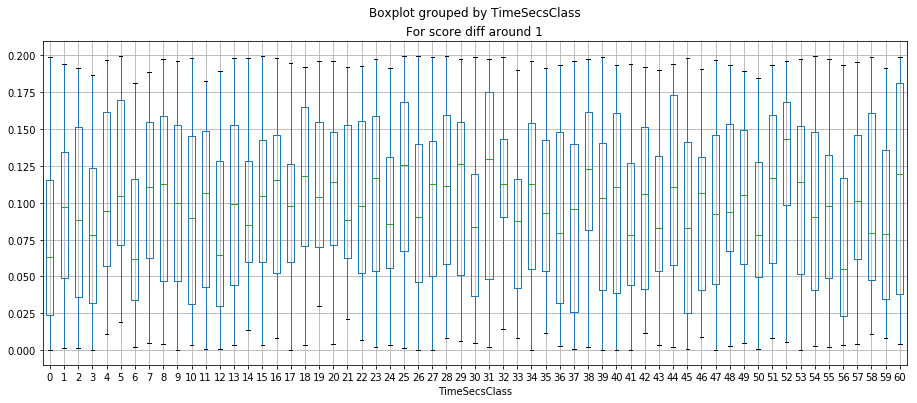

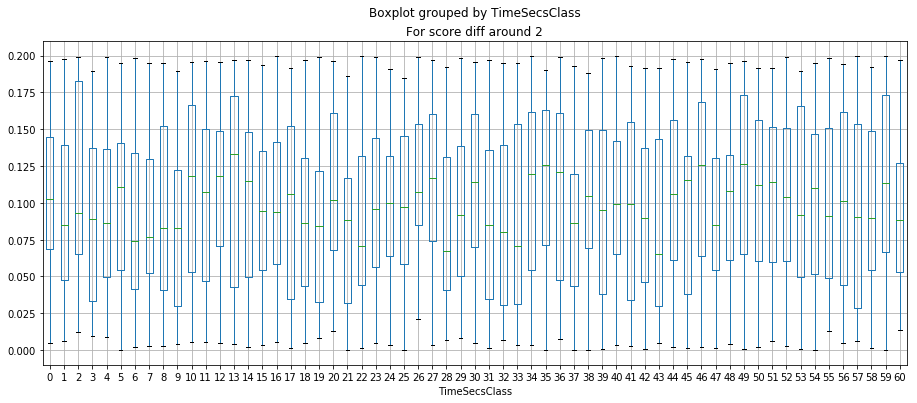

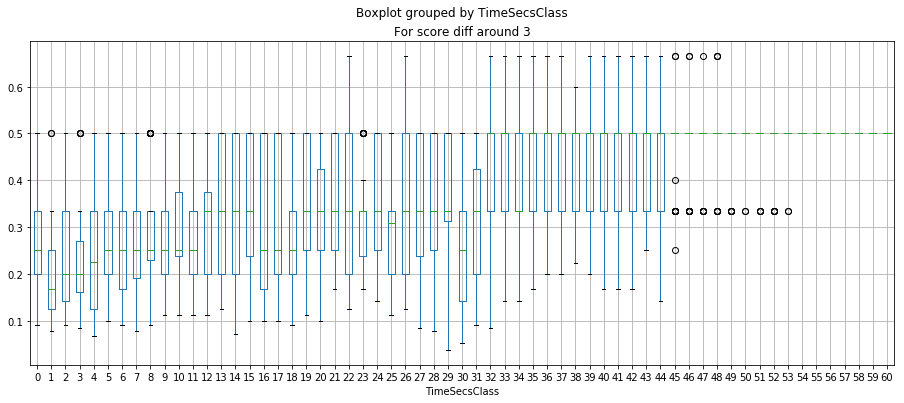

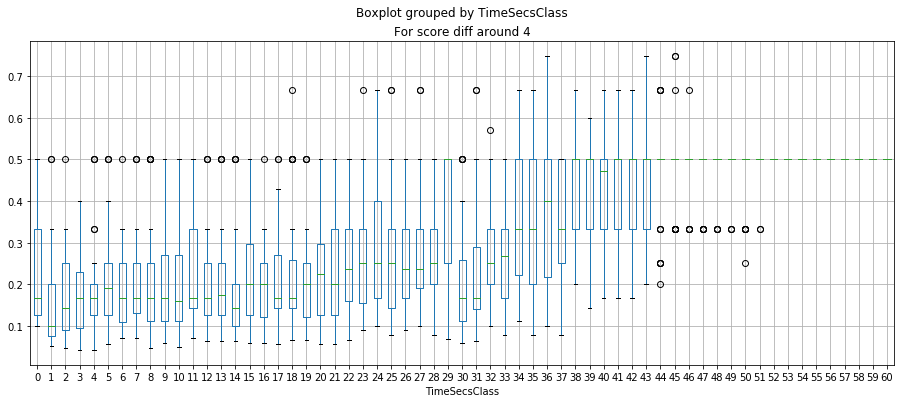

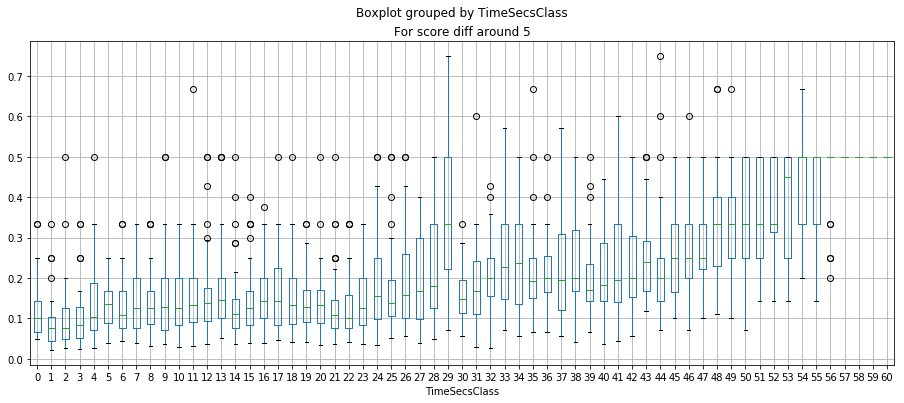

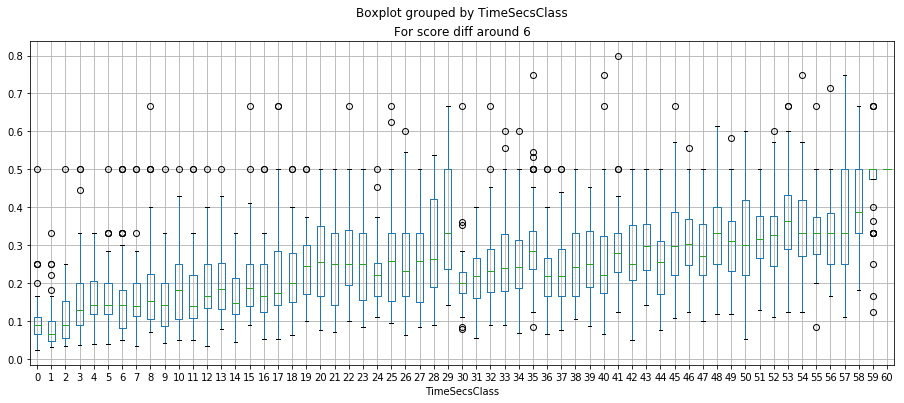

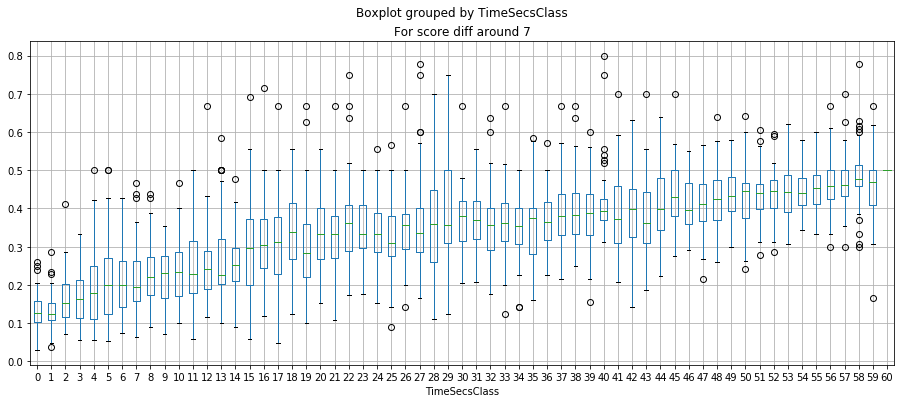

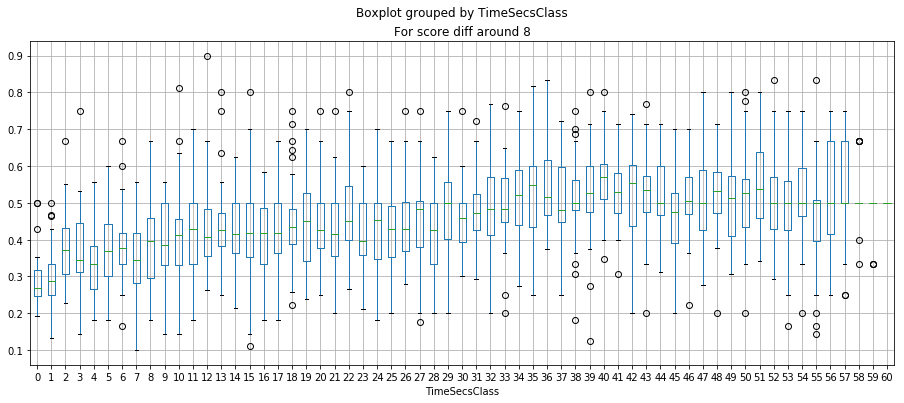

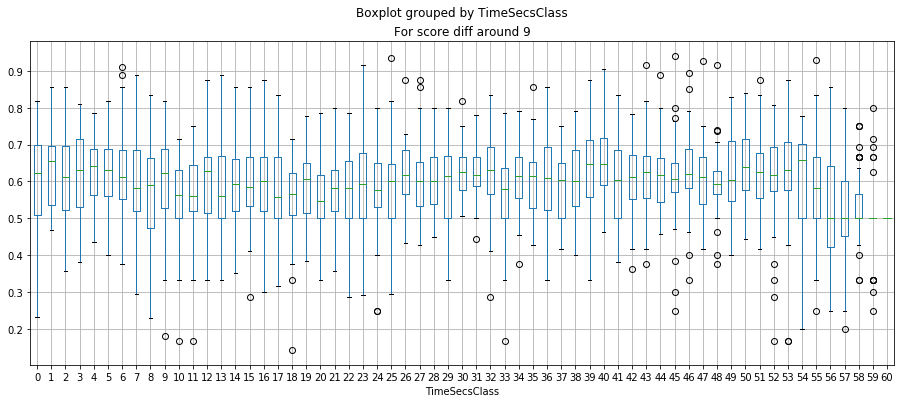

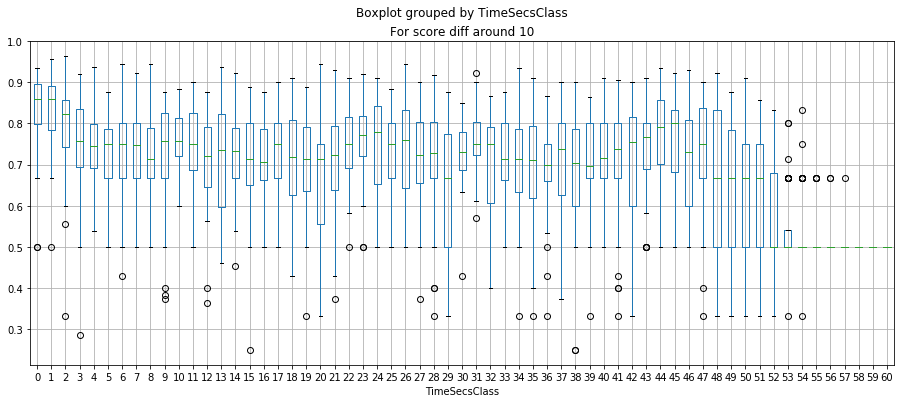

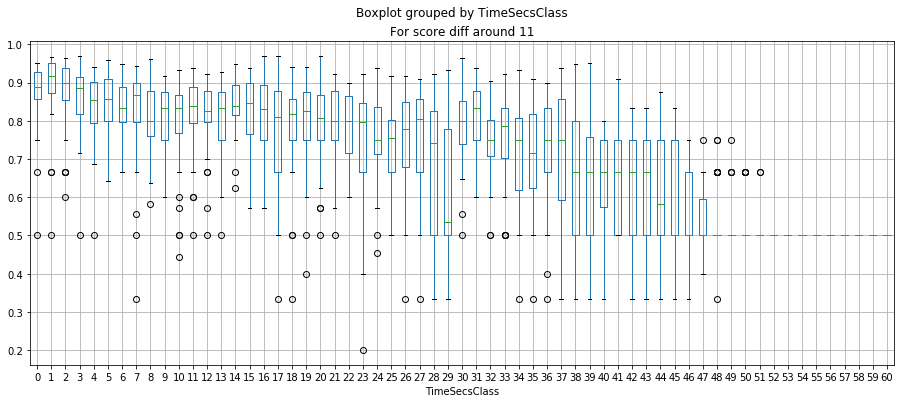

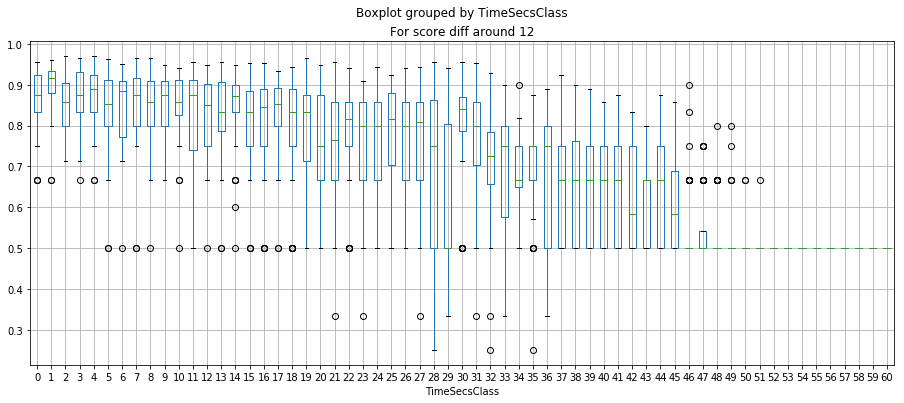

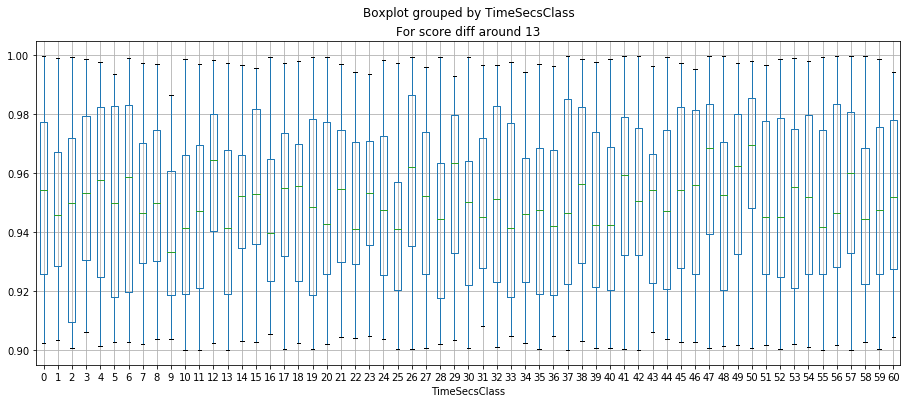

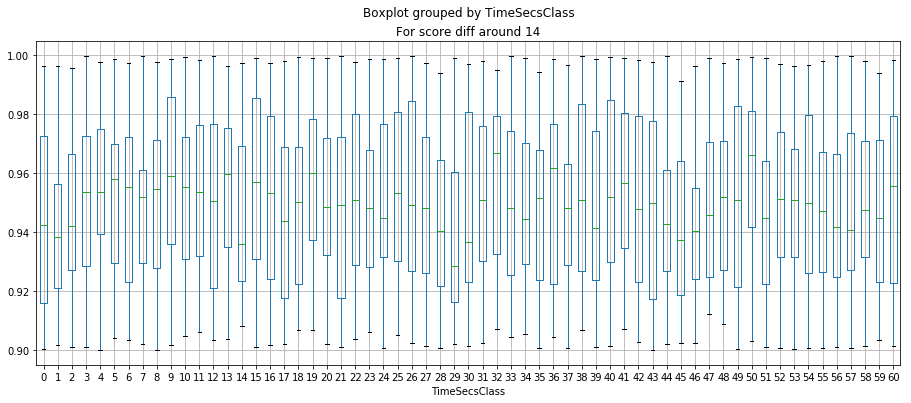

In [23]:
for i in prob_data.FavScoreDiffClass.unique():
    plot_data = prob_data[prob_data.FavScoreDiffClass == i]
    plt.figure()
#     sns.scatter(plot_data.TimeSecsClass, plot_data.counts)
    plot_data[['TimeSecsClass', 'counts']].boxplot(column='counts',by='TimeSecsClass')
    plt.title('For score diff around '+str(i))
    plt.show()

## Baseline Bucketing Result

In [53]:
play_cols = ['GameID','Drive','qtr','down','yrdline100','posteam','DefensiveTeam','TimeSecs','sp','ScoreDiff',
            'HomeTeam','AwayTeam']
spread_cols = ['eid','season','week','Home','Away','HomeScore','AwayScore','Day','Time','Favorite','Underdog','Spread','CoverOrNot']
data_files = glob.glob('data/new_data/pbp_20*.csv') # from 2009 to 2017

pbp_data = pd.DataFrame()
for f in data_files:
    d = pd.read_csv(f, usecols=play_cols)
    pbp_data = pd.concat([pbp_data, d])

spread_data = pd.read_csv('data/point_spread.csv')

data = pd.merge(pbp_data, spread_data, on='GameID', how='left')
data = data.dropna(axis=0, how='any')
data = data[data['TimeSecs'] >= 0]
data['FavScoreDiff'] = data[['posteam','ScoreDiff','Favorite']].apply(
    lambda x: x['ScoreDiff'] if x['posteam']==x['Favorite'] else (-x['ScoreDiff']),axis=1)

bins = [-np.inf, -35, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 35, np.inf] #15 items
data['FavScoreDiffClass'] = pd.cut(data['FavScoreDiff'],bins=bins, labels=range(14))
bins = range(0, 3601, 60)
bins.append(np.inf)
data['TimeSecsClass'] = pd.cut(data['TimeSecs'], bins=bins, labels=range(61), include_lowest=True)
bucket_cover = np.ones(shape=(14, 61))
bucket_notcover = np.ones(shape=(14, 61))

# TODO: Stupidly slow
bucket_cover_data = bucket_cover.copy()
bucket_notcover_data = bucket_notcover.copy()
for i, r in data.iterrows():
    score_idx = int(r['FavScoreDiffClass'])
    time_idx =  int(r['TimeSecsClass'])
    if r['CoverOrNot'] == 1:
        bucket_cover_data[score_idx][time_idx] += 1
    else:
        bucket_notcover_data[score_idx][time_idx] += 1

# Calculate initial probability based on bucket with data input
bucket_prob = bucket_cover_data.flatten() / (bucket_cover_data.flatten() + bucket_notcover_data.flatten())
bucket_prob = np.reshape(bucket_prob, (14, 61))

lin = linear_model.LinearRegression()
for i in range(14):
    lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[i])
    line_y = lin.predict(np.array(range(61)).reshape(-1, 1))
    for j in range(61):
        if i < 4:
            if line_y[j] < 0:
                bucket_prob[i][j] = 0
            elif line_y[j] > 0.5:
                bucket_prob[i][j] = 0.5
            else:
                bucket_prob[i][j] = line_y[j]
        elif i > 4:
            if line_y[j] > 1:
                bucket_prob[i][j] = 1
            elif line_y[j] < 0.5:
                bucket_prob[i][j] = 0.5
            else:
                bucket_prob[i][j] = line_y[j]

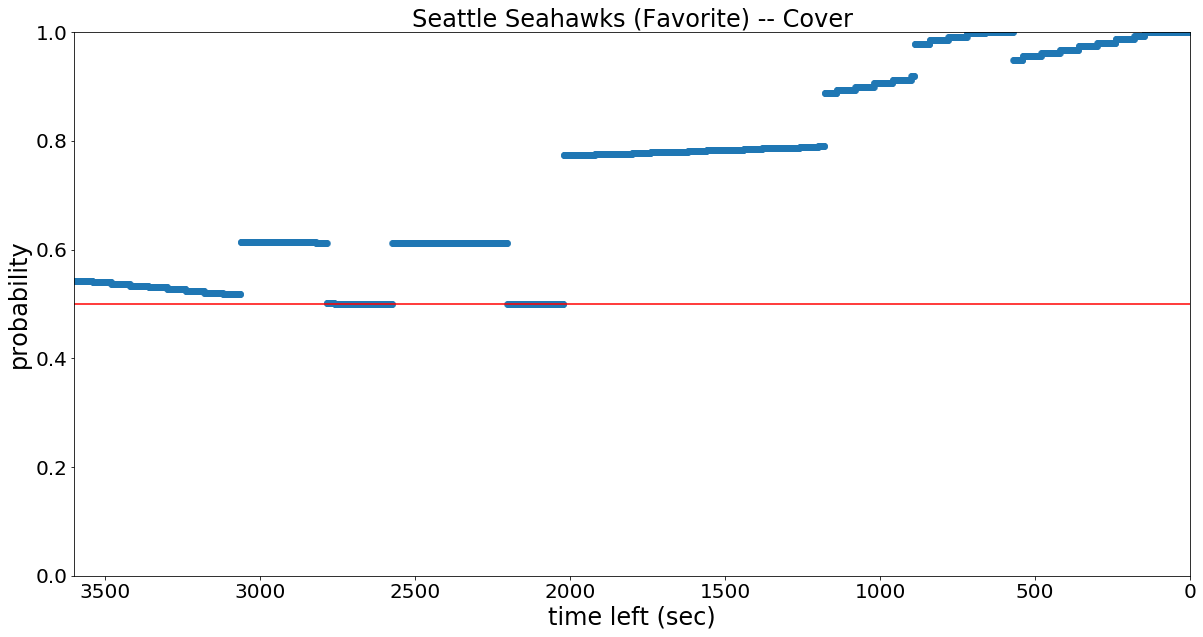

In [56]:
example = data[data['GameID'] == 2014090400]
example_score = []
example_score_dict = dict(zip(example.TimeSecs, example.FavScoreDiff))
# TODO: this might be consider a programming problem
time_unique = example.TimeSecs.unique()
curr_score_diff = 0
for t in range(3600, -1, -1):
    if t in time_unique:
        curr_score_diff = example[example["TimeSecs"] == t].FavScoreDiff.values[0]
    example_score.append(curr_score_diff)
example = pd.DataFrame(data=np.column_stack((range(3600, -1, -1), example_score)), columns=['timeleft', 'scorediff'])
bins = [-np.inf, -35, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 35, np.inf] #15 items
example['scorediffClass'] = pd.cut(example['scorediff'], bins=bins, labels=list(range(1,15)))
bins = range(0, 3601, 60)
bins.append(np.inf)
example['timeleftClass'] = pd.cut(example['timeleft'], bins=bins, labels=range(61), include_lowest=True)
for i, r in example.iterrows():
    score_idx = r['scorediffClass']
    time_idx  = r['timeleftClass']
    example.loc[i, 'prob'] = bucket_prob[score_idx][time_idx]
example

f, ax1 = plt.subplots(1, 1, figsize=(20, 10))


ax1.scatter(example.timeleft, example.prob, alpha=0.6)
# ax1.plot(d_f.lefttime, prob_f)
ax1.set_xlim(example.timeleft.max(), example.timeleft.min())
ax1.set_ylim(0, 1, 0.05)
ax1.axhline(y=0.5, color='r', linestyle='-')
ax1.set_title('Seattle Seahawks (Favorite) -- Cover', fontsize=24)
ax1.set_xlabel('time left (sec)', fontsize=24)
ax1.set_ylabel('probability', fontsize=24)
ax1.tick_params(labelsize=20)
plt.savefig('baseline-example.png')


plt.show()

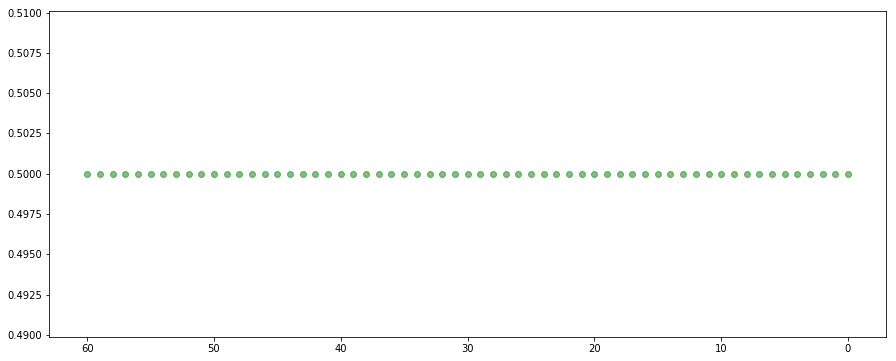

In [54]:
time = np.array(range(61))

bins = [-np.inf, -35, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 35, np.inf] #15 items
score_title = ['score diff <= -35',
              '-35 < score diff <= -25',
              '-25 < score diff <= -15',
              '-15 < score diff <= -10',
              '-10 < score diff <= -5',
              '-5 < score diff <= 0',
              '0 < score diff <= 5',
              '5 < score diff <= 10',
              '10 < score diff <= 15',
              '15 < score diff <= 20',
              '20 < score diff <= 25',
              '25 < score diff <= 35',
              'score diff <= -35',]

    

fig = plt.figure()
prob_idx = [True if p != 0.5 else False for p in bucket_prob[4]]
prob_fit = bucket_prob[4][prob_idx]
time_fit = time[prob_idx].reshape(-1, 1)
# lin.fit(time_fit, prob_fit)
# lin_y = lin.predict(time.reshape(-1, 1))
plt.scatter(range(61), bucket_prob[5], c="g", alpha=0.5)
# plt.plot(time.reshape(-1, 1), lin_y, color='cornflowerblue', linewidth=2,label='Linear regressor')
plt.gca().invert_xaxis()
plt.show()

# fig, ax = plt.subplots(nrows=14)
# for i, row in enumerate(ax):
#     prob_idx = [True if p != 0.5 else False for p in bucket_prob[i]]
#     prob_fit = bucket_prob[i][prob_idx]
#     time_fit = time[prob_idx].reshape(-1, 1)
#     lin.fit(time_fit, prob_fit)
#     lin_y = lin.predict(time.reshape(-1, 1))

#     row.scatter(range(61), bucket_prob[i], c="g", alpha=0.5)
#     row.plot(time.reshape(-1, 1), lin_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

#     row.set_title(score_title[i])
# plt.gca().invert_xaxis()
# plt.show()

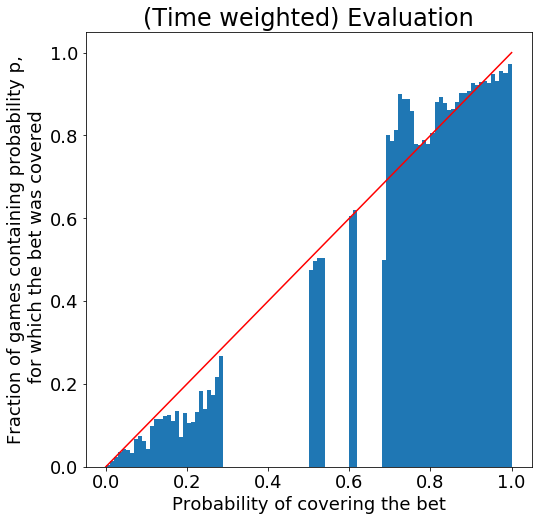

In [55]:
# Plot evaluation
for i, r in data.iterrows():
    score_idx = r['FavScoreDiffClass']
    time_idx  = r['TimeSecsClass']
    data.loc[i, 'prob'] = bucket_prob[score_idx][time_idx]
nbins = 100
numr = data.groupby('prob').apply(lambda x: x[x['CoverOrNot']==1]['GameID'].unique().shape[0])
numr = numr.reset_index()
numr.columns=['prob','count']

denr = data.groupby('prob').apply(lambda x: x['GameID'].unique().shape[0])
denr = denr.reset_index()
denr.columns=['prob','count']
numr_bins, bins_n = np.histogram(numr['prob'],weights=numr['count'],bins = nbins)
denr_bins, bins_d = np.histogram(denr['prob'],weights=denr['count'], bins=nbins)
final_values = [float(numr_bins[i])/float(denr_bins[i]+1) for i in range(100)]
fig,ax = plt.subplots(figsize=(8,8))
ax.bar(bins_d[:-1],final_values, width=np.diff(bins_d),align='edge')
x = np.linspace(0,1)
ax.plot(x,x,color='red')

ax.set_title('(Time weighted) Evaluation', fontsize=24)
ax.set_xlabel('Probability of covering the bet', fontsize=18)
ax.set_ylabel("Fraction of games containing probability p,\n for which the bet was covered", fontsize=18)
ax.tick_params(labelsize=18)

plt.show()